
## `Лабораторная работа №3 "Задачи NLP"`



#### Фамилия, имя: Игнаткин Максим

Дата выдачи: <span style="color:red">__11 декабря__</span>.

Срок сдачи: <span style="color:red">__25 декабря__</span>.

Максимальная оценка: __10 баллов__




## `Задание 1. Классификация текста с помощью RNN (5 баллов)`



[Данные](https://drive.google.com/drive/folders/1epWf0Wwixxv9juicjdCYYVz351vEe9yM?usp=drive_link) представляют собой тексты разных авторов. Обучающий набор содержит текст - его автора (метку к нему), всего 8 авторов. Тестовый набор содержит только тексты.

Необходимо решить задачу многоклассовой классификации текстов по авторам.

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from typing import List
import string
import time
import torch.optim as optim

import seaborn
seaborn.set(palette='summer')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Подготовка данных

Загрузим датасет и посмотрим на данные:

In [55]:
import pandas as pd
train_data = pd.read_csv('train_authors.csv')
train_data.head()

,text,author
0,"Студент, который все это нам рассказал, прилет...",Bulychev
1,"-Что не укладывается в голове,- произнес отец ...",Pratchett
2,"-Ш-ш-ш,- сказал я.- Спи.\n-Не могу,- ответила ...",King
3,-В Севастополь? Новое задание имеет отношение ...,Akunin
4,"-Ты прав,- сказал Сева.- Даже если это космиче...",Bulychev


In [56]:
test_data = pd.read_csv('test_authors.csv')
test_data.head()

,text
0,-Не выглядывал еще. Дрыхнет… Почему да почему?...
1,"Идти ему было немного; он даже знал, сколько ш..."
2,Придется вернуться в самое изголовье и начать ...
3,"-С ума сойти,- сказал отец. Он обернулся, увид..."
4,"Во-вторых, положение Петра после захвата власт..."


In [57]:
# Назначим каждому автору идентификатор
writers = ['Akunin', 'Bulychev', 'Chehov', 'Dostoevsky', 'Gogol', 'King',
          'Pratchett', 'Remark']
writers_to_label = {writer: i for i, writer in enumerate(writers)}
label_to_writers = {i: writer for i, writer in enumerate(writers)}

Подготовим данные для задачи классификации текстов по авторам, преобразуя сырые данные в словарь dataset['train'] и dataset['test'].


In [58]:
dataset = {}

dataset['train'] = [{'text':text, 'author':writers_to_label[label]} \
              for text, label in zip(np.array(train_data['text']), np.array(train_data['author']))]
dataset['test'] = [{'text':text, 'author': 0} \
              for text in np.array(test_data['text'])]

Можно сделать иначе используя класс `Dataset`.


In [59]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, authors):
        self.texts = texts
        self.authors = authors

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'author': self.authors[idx]}

**1)** Заведите Dataloader для загрузки данных нейронную сеть.

**2)** Разработайте и обучите RNN  на тренировочных данных.

Вкачестве рекуррентных слоёв можно выбрать:
- базовый RNN,
- LSTM,
- GRU,
- Применение двунаправленных рекуррентных слоев (Bidirectional RNN/LSTM/GRU).

**3)** Проведите эксперитенты с:
- Увеличением глубины модели. Используйте параметр `num_layers` для создания многослойной RNN.
При этом выходы каждого предыдущего слоя передаются в качестве входов следующему.

- Агрегацией выходных последовательностей. Помимо стандартных подходов (max, mean, last), рассмотрите, например, конкатенацию различных видов агрегации, использование различных пулинговых операций, или Ваш вариант.

**4)** Сделайте выводы и выберите модель с лучшей accuracy.

## 1. DataLoader

In [60]:
# Константы 
VOCAB_SIZE = 20000
MAX_SEQUENCE_LEN = 300
BATCH_SIZE = 32
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

def clean_and_tokenize(text):
    """
    Базовая предобработка: ловеркейс, удаление пунктуации, токенизация.
    """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return word_tokenize(text)

print("Начинаем сборку словаря...")

corpus_tokens = [clean_and_tokenize(item['text']) for item in dataset['train']]
print(f"Всего обработано текстов для словаря: {len(corpus_tokens)}")

token_counts = Counter()
for tokens in corpus_tokens:
    token_counts.update(tokens)

print(f"Всего уникальных токенов найдено: {len(token_counts)}")

top_tokens = token_counts.most_common(VOCAB_SIZE)
print(f"Оставляем топ-{VOCAB_SIZE} самых частых.")

token_to_id = {word: i + 2 for i, (word, _) in enumerate(top_tokens)}
token_to_id[PAD_TOKEN] = 0
token_to_id[UNK_TOKEN] = 1

id_to_token = {i: word for word, i in token_to_id.items()}

actual_vocab_size = len(token_to_id)
print(f"Итоговый размер словаря: {actual_vocab_size}")
print(f"Пример токенов: {list(token_to_id.items())[:5]}")

def text_to_indices(tokens, mapping):
    unk_id = mapping[UNK_TOKEN]
    return [mapping.get(t, unk_id) for t in tokens]

Начинаем сборку словаря...
Всего обработано текстов для словаря: 1734
Всего уникальных токенов найдено: 73242
Оставляем топ-20000 самых частых.
Итоговый размер словаря: 20002
Пример токенов: [('и', 2), ('в', 3), ('не', 4), ('на', 5), ('что', 6)]


In [61]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, targets, vocab_map, max_len):
        self.texts = texts
        self.targets = targets
        self.vocab = vocab_map
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        raw_text = self.texts[idx]
        tokens = clean_and_tokenize(raw_text)
        
        indices = text_to_indices(tokens, self.vocab)
        
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            padding = [self.vocab[PAD_TOKEN]] * (self.max_len - len(indices))
            indices += padding
            
        return {
            'input_ids': torch.tensor(indices, dtype=torch.long),
            'labels': torch.tensor(self.targets[idx], dtype=torch.long)
        }

In [62]:
print("Разделение данных на Train/Val")

all_texts = np.array(train_data['text'])
all_labels = np.array(train_data['author'].map(writers_to_label))

X_train, X_val, y_train, y_val = train_test_split(
    all_texts, all_labels, test_size=0.2, random_state=42
)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")

train_ds = TextClassificationDataset(X_train, y_train, token_to_id, MAX_SEQUENCE_LEN)
val_ds = TextClassificationDataset(X_val, y_val, token_to_id, MAX_SEQUENCE_LEN)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Dataloaders готовы")

print("Проверка первого батча")
sample_batch = next(iter(train_loader))
input_ids_shape = sample_batch['input_ids'].shape
labels_shape = sample_batch['labels'].shape

print(f"Shape входных данных (batch_size, seq_len): {input_ids_shape}")
print(f"Shape меток классов: {labels_shape}")
print(f"Тип данных тензора: {sample_batch['input_ids'].dtype}")

Разделение данных на Train/Val
Размер тренировочной выборки: 1387
Размер валидационной выборки: 347
Dataloaders готовы
Проверка первого батча
Shape входных данных (batch_size, seq_len): torch.Size([32, 300])
Shape меток классов: torch.Size([32])
Тип данных тензора: torch.int64


## 2. RNN (GRU)

Running on device: cuda
Модель инициализирована. Количество параметров: 2,660,360
Старт обучения
Epoch 1/5 finished in 1.5s
Result: Train Loss: 1.9744, Acc: 0.2307 | Val Loss: 1.9268, Acc: 0.2075

Epoch 2/5 finished in 1.4s
Result: Train Loss: 1.8459, Acc: 0.2812 | Val Loss: 1.9171, Acc: 0.2565

Epoch 3/5 finished in 1.5s
Result: Train Loss: 1.7752, Acc: 0.3180 | Val Loss: 1.9117, Acc: 0.2536

Epoch 4/5 finished in 1.5s
Result: Train Loss: 1.7105, Acc: 0.3389 | Val Loss: 1.9116, Acc: 0.2536

Epoch 5/5 finished in 1.6s
Result: Train Loss: 1.6307, Acc: 0.3735 | Val Loss: 1.9237, Acc: 0.1960

Обучение завершено


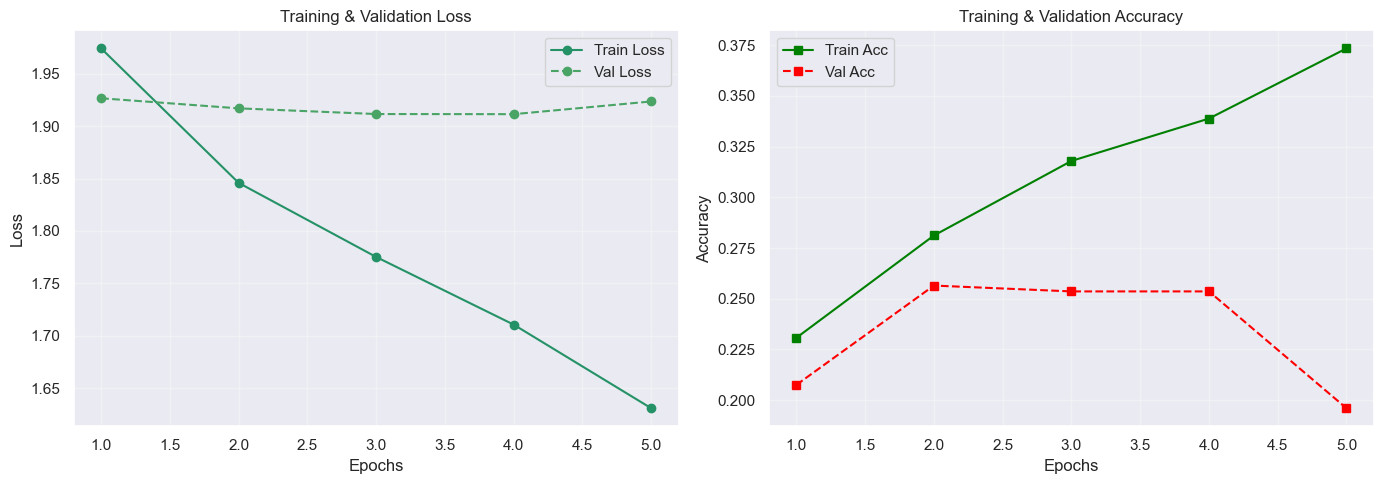

In [63]:
vocab_size = len(token_to_id)
class Config:
    vocab_size = vocab_size 
    embed_dim = 128
    hidden_dim = 128
    num_classes = len(writers)
    num_layers = 1
    bidirectional = False
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 5
    print_every = 50  
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running on device: {Config.device}")

class TextRNN(nn.Module):
    def __init__(self, config):
        super(TextRNN, self).__init__()
        
        # Слой эмбеддингов
        self.embedding = nn.Embedding(
            num_embeddings=config.vocab_size, 
            embedding_dim=config.embed_dim, 
            padding_idx=0
        )
        
        # Основной рекуррентный блок
        self.rnn = nn.GRU(
            input_size=config.embed_dim,
            hidden_size=config.hidden_dim,
            num_layers=config.num_layers,
            batch_first=True,
            bidirectional=config.bidirectional
        )
        
        rnn_out_dim = config.hidden_dim * (2 if config.bidirectional else 1)
        
        self.classifier = nn.Linear(rnn_out_dim, config.num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        
        output, hidden = self.rnn(embedded)

        last_hidden = hidden[-1]
        
        logits = self.classifier(last_hidden)
        return logits

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Инициализация
model = TextRNN(Config).to(Config.device)
print(f"Модель инициализирована. Количество параметров: {count_parameters(model):,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)

def run_training(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct_preds = 0
    total_samples = 0
    
    start_time = time.time()
    
    for i, batch in enumerate(loader):
        ids = batch['input_ids'].to(Config.device)
        labels = batch['labels'].to(Config.device)
        
        optimizer.zero_grad()
        outputs = model(ids)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # Статистика
        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        if (i + 1) % Config.print_every == 0:
            avg_loss = epoch_loss / (i + 1)
            print(f"   Step [{i+1}/{len(loader)}] | Current Loss: {avg_loss:.4f}")

    return epoch_loss / len(loader), correct_preds / total_samples

@torch.no_grad()
def run_evaluation(model, loader, criterion):
    model.eval()
    val_loss = 0
    correct_preds = 0
    total_samples = 0
    
    for batch in loader:
        ids = batch['input_ids'].to(Config.device)
        labels = batch['labels'].to(Config.device)
        
        outputs = model(ids)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
    return val_loss / len(loader), correct_preds / total_samples


history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("Старт обучения")

for epoch in range(Config.num_epochs):
    t0 = time.time()
    
    train_loss, train_acc = run_training(model, train_loader, optimizer, criterion)
    val_loss, val_acc = run_evaluation(model, val_loader, criterion)
    
    # Сохраняем метрики
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    duration = time.time() - t0
    print(f"Epoch {epoch+1}/{Config.num_epochs} finished in {duration:.1f}s")
    print(f"Result: Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}\n")

print("Обучение завершено")


def plot_metrics(history):
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # График Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], 'o--', label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], 's-', label='Train Acc', color='green')
    plt.plot(epochs_range, history['val_acc'], 's--', label='Val Acc', color='red')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_metrics(history)

На графиках видно переобучение ошибка на тренировочной выборке уверенно падает, в то время как валидационная точность вышла на плато в районе 25% и не растет. Текущая архитектура плохо обобщает данные, для улучшения результата стоит добавить регуляризацию или использовать двунаправленные слои.

## 3. GRU / LSTM


Running Experiment: Aggregation: Last
Params: {'vocab_size': 20002, 'num_layers': 3, 'rnn_type': 'gru', 'aggregation': 'last'}
[Epoch 1] Train Loss: 1.9474 | Val Acc: 0.2536
[Epoch 2] Train Loss: 1.8739 | Val Acc: 0.2651
[Epoch 3] Train Loss: 1.8028 | Val Acc: 0.2133
[Epoch 4] Train Loss: 1.6855 | Val Acc: 0.2738
[Epoch 5] Train Loss: 1.5971 | Val Acc: 0.2709
Experiment Aggregation: Last finished in 9.6s

Running Experiment: Aggregation: Mean
Params: {'vocab_size': 20002, 'num_layers': 3, 'rnn_type': 'gru', 'aggregation': 'mean'}
[Epoch 1] Train Loss: 1.9332 | Val Acc: 0.2853
[Epoch 2] Train Loss: 1.7466 | Val Acc: 0.3660
[Epoch 3] Train Loss: 1.5124 | Val Acc: 0.4035
[Epoch 4] Train Loss: 1.2705 | Val Acc: 0.4496
[Epoch 5] Train Loss: 0.9689 | Val Acc: 0.5130
Experiment Aggregation: Mean finished in 9.4s

Running Experiment: Aggregation: Max
Params: {'vocab_size': 20002, 'num_layers': 3, 'rnn_type': 'gru', 'aggregation': 'max'}
[Epoch 1] Train Loss: 1.9527 | Val Acc: 0.2536
[Epoch 2]

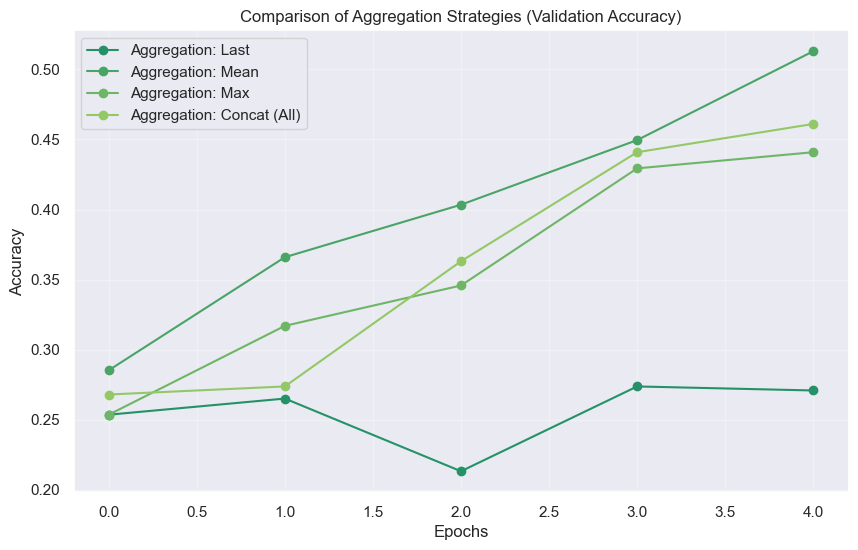

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

class AdvancedRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, 
                 num_layers=2, num_classes=8, rnn_type='gru', 
                 bidirectional=False, aggregation='last'):
        super().__init__()
        
        self.aggregation = aggregation
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        rnn_cls = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[rnn_type.lower()]
        
        self.rnn = rnn_cls(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Расчет размерности перед классификатором
        rnn_out_dim = hidden_dim * (2 if bidirectional else 1)
        
        if aggregation == 'concat':
            rnn_out_dim = rnn_out_dim * 3
            
        self.classifier = nn.Linear(rnn_out_dim, num_classes)
        self.dropout = nn.Dropout(0.3) # Добавим немного регуляризации

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, _ = self.rnn(embedded)
        
        if self.aggregation == 'last':
            if self.bidirectional:
                half = outputs.size(2) // 2
                out = torch.cat((outputs[:, -1, :half], 
                                 outputs[:, 0, half:]), dim=1)
            else:
                out = outputs[:, -1, :]
                
        elif self.aggregation == 'mean':
            out = outputs.mean(dim=1)
            
        elif self.aggregation == 'max':
            out, _ = outputs.max(dim=1)
            
        elif self.aggregation == 'concat':
            if self.bidirectional:
                 last = outputs[:, -1, :] 
            else:
                 last = outputs[:, -1, :]
                 
            mean_pool = outputs.mean(dim=1)
            max_pool, _ = outputs.max(dim=1)
            out = torch.cat([last, mean_pool, max_pool], dim=1)
            
        else:
            raise ValueError(f"Unknown aggregation: {self.aggregation}")

        return self.classifier(self.dropout(out))

def run_experiment(name, model_params, train_loader, val_loader, num_epochs=5):
    print(f"\n{'='*20}\nRunning Experiment: {name}\nParams: {model_params}\n{'='*20}")
    
    # Инициализация
    model = AdvancedRNN(**model_params).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    start_total = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        t_loss = 0
        for batch in train_loader:
            ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            logits = model(ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            
        avg_train_loss = t_loss / len(train_loader)
        
        model.eval()
        v_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                logits = model(ids)
                
                v_loss += criterion(logits, labels).item()
                correct += (logits.argmax(1) == labels).sum().item()
                total += labels.size(0)
        
        avg_val_loss = v_loss / len(val_loader)
        val_acc = correct / total
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")

    print(f"Experiment {name} finished in {time.time() - start_total:.1f}s")
    return history

# Рубрика ЭЭЭЭЭксперименты
experiment_configs = [
    {
        'name': 'Aggregation: Last',
        'params': {
            'vocab_size': vocab_size,
            'num_layers': 3,
            'rnn_type': 'gru',
            'aggregation': 'last'
        }
    },
    {
        'name': 'Aggregation: Mean',
        'params': {
            'vocab_size': vocab_size,
            'num_layers': 3,
            'rnn_type': 'gru',
            'aggregation': 'mean'
        }
    },
    {
        'name': 'Aggregation: Max',
        'params': {
            'vocab_size': vocab_size,
            'num_layers': 3,
            'rnn_type': 'gru',
            'aggregation': 'max'
        }
    },
    {
        'name': 'Aggregation: Concat (All)',
        'params': {
            'vocab_size': vocab_size,
            'num_layers': 3,
            'rnn_type': 'gru',
            'aggregation': 'concat'
        }
    }
]

results = {}

for exp in experiment_configs:
    hist = run_experiment(
        exp['name'], 
        exp['params'], 
        train_loader, 
        val_loader, 
        num_epochs=5
    )
    results[exp['name']] = hist

plt.figure(figsize=(10, 6))

for name, hist in results.items():
    plt.plot(hist['val_acc'], marker='o', label=name)

plt.title('Comparison of Aggregation Strategies (Validation Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Использование последнего скрытого состояния Last показало наихудший результат с низкой и нестабильной точностью ~20-25%, что говорит о потере контекста к концу последовательности. В то же время методы агрегации Mean и Concat кардинально улучшили качество обучения, подняв точность на валидации до 45% и выше. Это подтверждает, что для классификации данных текстов критически важно учитывать признаки со всей длины последовательности, а не только финальный вектор RNN.

### Инференс модели

Ниже функция для оценки точности модели на данных из DataLoader.

Здесь model — ваша обученная модель, dataloader — test_dataloader, построенный на основе тестовой части данных (dataset['test']).

In [65]:
label_to_writers = {v: k for k, v in writers_to_label.items()}
test_texts = np.array([item['text'] for item in dataset['test']])
dummy_labels = np.zeros(len(test_texts)) 

test_dataset = TextClassificationDataset(
    texts=test_texts, 
    targets=dummy_labels, 
    vocab_map=token_to_id, 
    max_len=MAX_SEQUENCE_LEN
)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [66]:
def get_predictions(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """
    model.eval()
    predictions = []
    
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            logits = model(input_ids)
            predictions.append(logits.argmax(dim=1))

    predictions = torch.cat(predictions).data.cpu().numpy()
    return predictions


In [ ]:
print("Начинаем предсказание")
raw_predictions = get_predictions(model, test_dataloader)

final_predictions = [label_to_writers[x] for x in raw_predictions]

print("Примеры предсказаний:")
print(final_predictions[:10])

submission = pd.DataFrame({'id': range(len(final_predictions)), 'author': final_predictions})
submission.to_csv('submission.csv', index=False)
print("\nФайл 'submission.csv' успешно сохранен!")

Начинаем предсказание


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Примеры предсказаний:
['Bulychev', 'Dostoevsky', 'Bulychev', 'Bulychev', 'Pratchett', 'Bulychev', 'Bulychev', 'Akunin', 'Bulychev', 'Bulychev']

Файл 'submission.csv' успешно сохранен!


### Сохраните результат

In [69]:
np.save('submission_rnn03.npy', final_predictions, allow_pickle=True)
print('Ответ сохранен в файл `submission_rnn03.npy`')

Ответ сохранен в файл `submission_rnn03.npy`


## `Задание 2. Классификация текста с помощью предобученной языковой модели BERT (3 балла)`

Рассматривается [датасет](https://drive.google.com/drive/folders/151O9W-yp6TMP0Wmrm_wzbu8F7sq4cm_4?usp=sharing)
**SST-2** (Stanford Sentiment Treebank версии 2).


In [70]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output

### Загрузка данных


`holdout_texts.npy` - файл содержит holdout выборку.

holdout выборка - это отдельная часть неразмеченных данных, которая НЕ используется при обучении модели и служит исключительно для финальной оценки её качества после завершения всех экспериментов.

`STT2_train_task.tsv` - файл с обучающей выборкой.


In [72]:
# преобразуем holdout-выборку в numpy.array
texts_holdout = np.load('SST2/holdout_texts.npy', allow_pickle=True)
texts_holdout[:5]

array(['gee , a second assassin shot kennedy ?',
       "from the big giant titles of the opening credits to elmer bernstein 's perfectly melodic score , haynes gets just about everything right",
       'the movie is well shot and very tragic , and one to ponder after the credits roll',
       'the movie quickly drags on becoming boring and predictable',
       "a mixed bag of a comedy that ca n't really be described as out of this world"],
      dtype=object)

In [73]:
# Загрузим обучающие и тестовые размеченные данные
df = pd.read_csv('SST2/STT2_train_task.tsv.txt',delimiter='\t',header=None)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6920 entries, 0 to 6919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       6920 non-null   object
 1   1       6920 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


In [75]:
# реализуем простое разделение на обучающую и тестовую части
# 73% - обучающая, 27% - тестовая
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]


**1)** Напишите функцию получения эмбеддингов.

Сначала необходимо получить эмбендинги предложений с помощью обученной `BERT':

- Загрузить предобученный токенизатор и модель.

- Токенизировать текст с добавлением специальных токенов и преобразовать в тензоры.

Функция
`tokenizer.encode(text, add_special_tokens=True)`
возвращает ID токенов.

- Пропустить через модель и получить выходы.

- Извлечь эмбеддинг для всего предложения (возьмем скрытое состояние, соответствующее [CLS] токену).



In [76]:
from transformers import AutoTokenizer, AutoModel

def get_bert_embeddings(text, model, tokenizer, pooling_strategy='cls'):
    """
    Получение эмбеддингов текста с помощью BERT

    Args:
        text: строка или список строк
        model: предобученная модель BERT
        tokenizer: токенизатор BERT
        pooling_strategy: стратегия пулинга ('cls', 'mean', 'max')

    Returns:
        Векторное представление текста
    """
    device = next(model.parameters()).device
    
    inputs = tokenizer(
        text, 
        return_tensors='pt',    
        padding=True,           
        truncation=True,   
        max_length=512
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_state = outputs.last_hidden_state

    if pooling_strategy == 'cls':
        embeddings = last_hidden_state[:, 0, :]
        
    elif pooling_strategy == 'mean':
        embeddings = last_hidden_state.mean(dim=1)
        
    elif pooling_strategy == 'max':
        embeddings, _ = last_hidden_state.max(dim=1)
        
    else:
        raise ValueError(f"Unknown pooling strategy: {pooling_strategy}")
    return embeddings.cpu().numpy()


**2)** Обучите логистическую регрессию

Датасет для обучения логистической регрессии состоит из векторов, полученных из предобученной модели BERT. В качестве признаков используются эмбеддинги токена [CLS], которые извлекаются из выходного слоя трансформерного блока модели.
Каждая строка датасета соответствует отдельному предложению, а столбцы представляют активации скрытых нейронов полносвязного слоя, следующего за трансформерной архитектурой. Эти векторные представления служат входными признаками для классификатора.

Ваша модель должна давать точность > 80%

In [77]:
MODEL_NAME = 'bert-base-uncased' 

print(f"Downloading & Loading model: {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)
bert_model.eval() 

print(f"Модель успешно загружена на устройство: {device}")

Модель успешно загружена на устройство: cuda


In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

def extract_features(text_list, model, tokenizer, batch_size=32, device=None):
    """
    Прогоняет список текстов через BERT батчами, чтобы не взорвать память.
    """
    if device is None:
        device = next(model.parameters()).device
    
    if hasattr(text_list, 'tolist'):
        text_list = text_list.tolist()
        
    embeddings = []
    
    for i in tqdm(range(0, len(text_list), batch_size), desc="Embedding extraction"):
        batch_texts = text_list[i : i + batch_size]

        batch_emb = get_bert_embeddings(
            batch_texts, 
            model, 
            tokenizer, 
            pooling_strategy='cls'
        )
        embeddings.append(batch_emb)
        
    return np.vstack(embeddings)

print("Генерируем эмбеддинги для Train")
X_train_emb = extract_features(texts_train, bert_model, tokenizer, batch_size=32)

print("Генерируем эмбеддинги для Test")
X_test_emb = extract_features(texts_test, bert_model, tokenizer, batch_size=32)

print("Генерируем эмбеддинги для Holdout")
X_holdout_emb = extract_features(texts_holdout, bert_model, tokenizer, batch_size=32)

print(f"\nРазмеры матриц:\nTrain: {X_train_emb.shape}\nTest: {X_test_emb.shape}")
print("Обучение Logistic Regression")


clf = LogisticRegression(
    C=1.0,
    max_iter=2000,      
    solver='lbfgs',
    n_jobs=-1,        
    random_state=42
)

clf.fit(X_train_emb, y_train)


train_preds = clf.predict(X_train_emb)
test_preds = clf.predict(X_test_emb)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print("-" * 30)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print("-" * 30)

# Проверка условия
if test_acc > 0.80:
    print("Точность выше 80%.")
else:
    print("Печаль: точность ниже 80%.")



Генерируем эмбеддинги для Train


Embedding extraction:   0%|          | 0/157 [00:00<?, ?it/s]

Генерируем эмбеддинги для Test


Embedding extraction:   0%|          | 0/60 [00:00<?, ?it/s]

Генерируем эмбеддинги для Holdout


Embedding extraction:   0%|          | 0/16 [00:00<?, ?it/s]


Размеры матриц:
Train: (5000, 768)
Test: (1920, 768)
Обучение Logistic Regression
------------------------------
Train Accuracy: 0.9110
Test Accuracy:  0.8453
------------------------------
Точность выше 80%.



Сохраните в словарь `out_dict` вероятности принадлежности к нулевому и первому классу соответственно, для кадой выборки:

In [79]:
out_dict = {
    'train': clf.predict_proba(X_train_emb),
    'test': clf.predict_proba(X_test_emb),
    'holdout': clf.predict_proba(X_holdout_emb)
}


### Сохраните результат

In [ ]:
print("\nСохранение предсказаний...")
for k, v in out_dict.items():
    print(f"{k} shape: {v.shape}")

filename = 'submission_bert03.npy'
np.save(filename, out_dict, allow_pickle=True)
print(f"Файл сохранен: {filename}")

## `Задание 3. Реализовать механизм внимания (2 балла)`


Рассмотрим архитектуру энкодера-декодера, где энкодер преобразует входную последовательность в набор скрытых состояний $h_{e1}, ..., h_{eN}$, а декодер генерирует выходную последовательность, используя свои состояния $h_{dt}$ в каждый момент времени $t$.


**Вектор внимания** $a_{dt}$ в момент времени $t$ представляет собой распределение важности по всем состояниям энкодера:


$$a_{dt} = [a_{i,t},...,a_{N, t}]$$


где каждый элемент $a_{i, t} = f(h_{ei}, h_{dt})$ вычисляется с помощью функции внимания $f$, оценивающей релевантность $i$-го состояния энкодера текущему состоянию декодера.

**Типы функций внимания**:

1. **Внимание на основе скалярного произведения (Dot-Product Attention)**
Самый простой и вычислительно эффективный подход, непосредственно измеряющий сходство между векторами:

$$f(h_{ei}, h_{dt}) = h_{dt}^Th_{ei}$$

Преимущества:

- Минимальные вычислительные затраты.

- Не требует дополнительных обучаемых параметров.

2. **Мультипликативное внимание (Multiplicative Attention)**

Вводит обучаемую матрицу весов $W$ для моделирования взаимодействий между пространствами энкодера и декодера:

$$f(h_{ei}, h_{dt}) = h_{dt}^T*W*h_{ei}$$

Преимущества:

- Позволяет моделировать более сложные взаимосвязи.

- Матрица $W$ адаптируется в процессе обучения.

- Эффективнее скалярного произведения при разных размерностях векторов.

3. **Аддитивное внимание (Additive Attention)**
Использует двухслойную нейронную сеть с нелинейной активацией (например, tanh) для вычисления оценки внимания:

$$f(h_{ei}, h_{dt}) = v^T*tanh(W_1*h_{ei}+W_2*h_{dt})$$

где $W_1$, $W_2$ — матрицы весов, а $v$ — вектор весов для получения скалярного значения.

Преимущества:

- Более выразительная модель за счет нелинейности.

- Подходит для случаев, когда прямого сходства между векторами недостаточно.



In [81]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output


#### Dot product attention (пример реализации)

Рассмотрим единственное состояние энкодера – вектор с размерностью `(n_hidden, 1)`, где `n_hidden = 3` - размерность вектора, который определяет единственное состояние энкодера:

Text(0.5, 1.0, 'Decoder state')

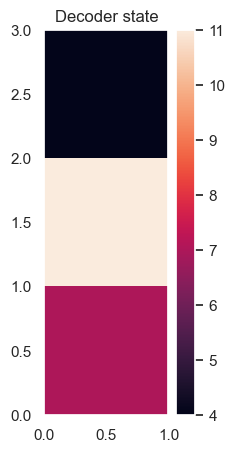

In [82]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title('Decoder state')

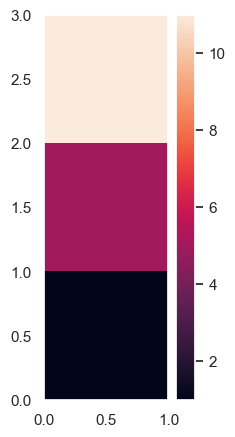

In [83]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

In [84]:
# вектор внимания как скалярное произведение
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

array([[106.]])

Обобщим на случай, когда у энкодера несколько скрытых состояний:

In [85]:
encoder_hidden_states = np.array([
    [1, 5, 11],
    [7, 4, 1],
    [8, 12, 2],
    [-9, 0, 1]

]).astype(float).T

encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.]])

In [86]:
# функция подсчета скалярных произведений
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)

    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    '''
    attention_scores = np.dot(decoder_hidden_state.T, encoder_hidden_states)
    return attention_scores

In [87]:
# вектор скрытого состояния
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

array([[106.,  97., 196., -59.]])

In [88]:
#
def softmax(vector):
    '''
    vector: np.array of shape (n, m)

    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    '''
    nice_vector = vector - vector.max()
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

In [89]:
# вектор весов всех состояний
weights_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))

weights_vector

array([[8.19401262e-040, 1.01122149e-043, 1.00000000e+000,
        1.79848622e-111]])

**Итоговый вектор внимания** представляет собой взвешенную сумму всех состояний энкодера, где веса определяются релевантностью каждого состояния энкодера текущему состоянию декодера.


In [90]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)

    return: np.array of shape (n_features, 1)
        Final attention vector
    '''
    softmax_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

**1)** Реализуйте мультипликативное внимание

In [91]:
encoder_hidden_states_complex = np.array([
    [1, 5, 11, 4, -4],
    [7, 4, 1, 2, 2],
    [8, 12, 2, 11, 5],
    [-9, 0, 1, 8, 12]

]).astype(float).T

# Дана матрица весов
W_mult = np.array([
    [-0.78, -0.97, -1.09, -1.79,  0.24],
    [ 0.04, -0.27, -0.98, -0.49,  0.52],
    [ 1.08,  0.91, -0.99,  2.04, -0.15]
])

In [92]:
def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)

    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    score_projection = np.dot(decoder_hidden_state.T, W_mult)
    raw_scores = np.dot(score_projection, encoder_hidden_states)
    attention_weights = softmax(raw_scores)
    attention_vector = np.dot(encoder_hidden_states, attention_weights.T)
    return attention_vector

In [93]:
print("Вычисляем Multiplicative Attention")
attention_vector = multiplicative_attention(decoder_hidden_state, 
                                            encoder_hidden_states_complex, 
                                            W_mult)

print(f"Размерность результата: {attention_vector.shape}")
print(f"Полученный вектор внимания:\n{attention_vector}")

Вычисляем Multiplicative Attention
Размерность результата: (5, 1)
Полученный вектор внимания:
[[-9.00000000e+00]
 [ 1.01553049e-19]
 [ 1.00000000e+00]
 [ 8.00000000e+00]
 [ 1.20000000e+01]]


#### Сохраните результат

In [94]:
filename = 'submission_att03.npy'
np.save(filename, attention_vector, allow_pickle=True)
print(f"Ответ успешно сохранен в файл `{filename}`")

Ответ успешно сохранен в файл `submission_att03.npy`
